In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, math
from tqdm.notebook import tqdm
import copy

import csv
import re

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from einops import rearrange, reduce, repeat

In [3]:
import parser
import transformer
import longrange
import dataset
import train
import util

In [4]:
ids_book = parser.book2ids()

In [5]:
ds_train, ds_test = dataset.load_dataset(tqdm=tqdm)

Found existing dataset at ../data/datasets.pkl


In [77]:
word2freq, fbin2wordset, word2fbin = calc_word_freq_bins(tqdm=tqdm)

0it [00:00, ?it/s]

In [78]:
fbin2size = [len(i) for i in fbin2wordset]
fbin2prob = [sum([word2freq[word] for word in i]) for i in fbin2wordset]

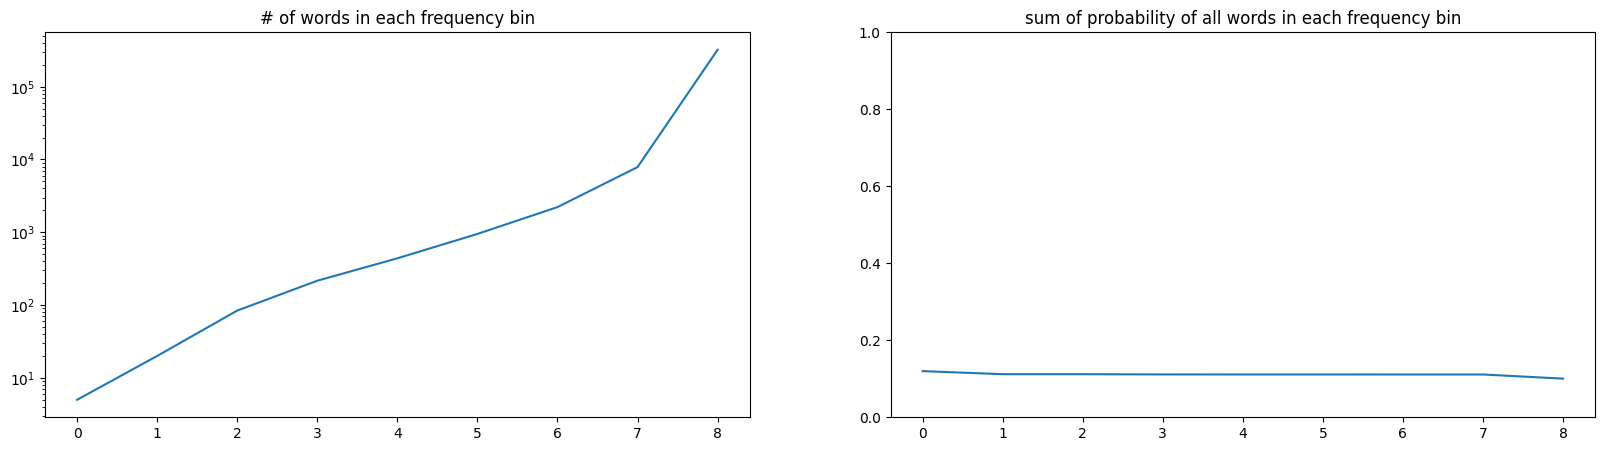

In [79]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(fbin2size); plt.yscale('log')
plt.title('# of words in each frequency bin')
plt.subplot(122); plt.plot(fbin2prob); plt.ylim(0, 1)
plt.title('sum of probability of all words in each frequency bin')
plt.show()

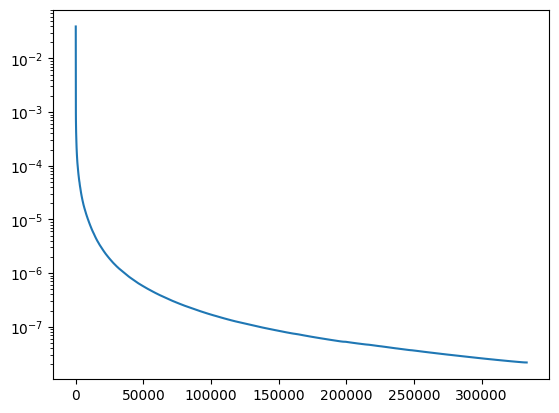

In [80]:
plt.plot(word2freq.values())
plt.yscale('log')

In [27]:
text_book = parser.book2text('../data/Gutenberg/txt/Abraham Lincoln___Lincoln Letters.txt')

In [28]:
import nltk#.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /afs/csail.mit.edu/u/a/akumar01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [174]:
def create_dataset(dir_data="../data/Gutenberg/txt", percent_train=0.8, tqdm=None):
    ds = {}
    files = os.listdir(dir_data)
    print(f'Loading {len(files)} books')
    files = [f'{dir_data}/{file}' for file in files]
    
    pbar = tqdm(files[:100]) if tqdm is not None else files
    for file in pbar:
        try:
            # ids = parser.book2ids(file)
            book_data = parser.process_text(parser.book2text(file), word2fbin)
            if len(book_data['ids']) > 0:
                ds[file] = book_data
        except Exception as e:
            print(e)

    books_all = sorted(list(ds.keys())).copy()
    np.random.seed(0)
    np.random.shuffle(books_all)
    train_split_idx = int(len(books_all) * percent_train)
    books_train, books_test = books_all[:train_split_idx], books_all[train_split_idx:]

    ds_train, ds_test = {k: ds[k] for k in books_train}, {k: ds[k] for k in books_test}
    return ds_train, ds_test

ds_train, ds_test = create_dataset(tqdm=tqdm)



Loading 3037 books


  0%|          | 0/100 [00:00<?, ?it/s]

In [175]:
len(ds_train)

80

In [176]:
data = ds_train['../data/Gutenberg/txt/Andrew Lang___Adventures among Books.txt']

In [177]:
data['words']

array(['adventures', 'among', 'books', ..., 'i', 'can', 'edinburgh'],
      dtype='<U17')

In [187]:
data['fbin_fchars'][-100:]

array([-2, -2, -2,  1, -2, -2, -2, -2,  8, -2, -2, -2, -2, -2,  0, -2,  8,
       -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2,  8, -2, -2, -2, -2,
       -2, -2,  0, -2, -2, -2,  5, -2, -2, -2, -2, -2, -2,  6, -2, -2, -2,
       -2, -2, -2,  1, -2,  2, -2, -2,  7, -2, -2, -2, -2, -2, -2,  1, -2,
       -2, -2, -2,  1, -2,  2, -2, -2, -2, -2, -2, -2, -2, -2, -2,  7, -2,
       -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
      dtype=int8)

In [190]:
word2fbin['i']

1

In [178]:
data['text']

'\nADVENTURES AMONG BOOKS\nby Andrew Lang\nContents:\nPreface\nAdventures Among Books\nRecollections of Robert Louis Stevenson\nRab\'s Friend\nOliver Wendell Holmes\nMr. Morris\'s Poems\nMrs. Radcliffe\'s Novels\nA Scottish Romanticist of 1830\nThe Confessions of Saint Augustine\nSmollett\nNathaniel Hawthorne\nThe Paradise of Poets\nParis and Helen\nEnchanted Cigarettes\nStories and Story-telling\nThe Supernatural in Fiction\nAn Old Scottish Psychical Researcher\nThe Boy\nPREFACE\nOf the Essays in this volume "Adventures among Books," and "Rab\'s\nFriend," appeared in _Scribner\'s Magazine_; and "Recollections of Robert\nLouis Stevenson" (to the best of the author\'s memory) in _The North\nAmerican Review_. The Essay on "Smollett" was in the _Anglo-Saxon_,\nwhich has ceased to appear; and the shorter papers, such as "The\nConfessions of Saint Augustine," in a periodical styled _Wit and Wisdom_.\nFor "The Poems of William Morris" the author has to thank the Editor of\n_Longman\'s Magazi